In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score
from torch.utils.data import TensorDataset, DataLoader
from torch import nn, optim
import torch as th

In [2]:
seed = 42
np.random.seed(seed)
th.manual_seed(seed)
if th.cuda.is_available():
    th.cuda.manual_seed_all(seed)

In [3]:
data_train = pd.read_csv('./rent-prediction/train.csv')
data_test = pd.read_csv('./rent-prediction/test.csv')
data_train.head(3)

,author,author_type,location,deal_type,accommodation_type,floor,floors_count,rooms_count,total_meters,price_per_month,commissions,district,street,house_number,underground,ID
0,67квартир,real_estate_agent,Смоленск,rent,flat,15.0,19.0,1.0,42.0,50000,0.0,Ленинский,Ново-Чернушенский переулок,5,NaN,1
1,Олег Тарасов,NaN,Подольск,rent,flat,1.0,3.0,1.0,37.0,38000,0.0,мкр. Силикатная,проезд Авиаторов,NaN,NaN,2
2,АЛЬФА,real_estate_agent,Иваново,rent,flat,15.0,32.0,2.0,63.0,280000,0.0,Дорогомилово,Поклонная,9,Поклонная,3


In [4]:
data_train.shape

(2464, 16)

In [5]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2464 entries, 0 to 2463
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   author              2337 non-null   object 
 1   author_type         2334 non-null   object 
 2   location            2339 non-null   object 
 3   deal_type           2339 non-null   object 
 4   accommodation_type  2340 non-null   object 
 5   floor               2338 non-null   float64
 6   floors_count        2334 non-null   float64
 7   rooms_count         2344 non-null   float64
 8   total_meters        2335 non-null   float64
 9   price_per_month     2464 non-null   int64  
 10  commissions         2340 non-null   float64
 11  district            1832 non-null   object 
 12  street              2329 non-null   object 
 13  house_number        2332 non-null   object 
 14  underground         1702 non-null   object 
 15  ID                  2464 non-null   int64  
dtypes: flo

In [6]:
data_train.select_dtypes(np.number).min()

floor                 1.0
floors_count          1.0
rooms_count          -1.0
total_meters          5.8
price_per_month    7000.0
commissions           0.0
ID                    1.0
dtype: float64

In [7]:
data_train.loc[data_train['rooms_count'] < 1, 'rooms_count'] = np.nan
data_test.loc[data_train['rooms_count'] < 1, 'rooms_count'] = np.nan

In [8]:
dup_ix = data_train.drop(columns=['ID']).duplicated()
data_train[dup_ix]

,author,author_type,location,deal_type,accommodation_type,floor,floors_count,rooms_count,total_meters,price_per_month,commissions,district,street,house_number,underground,ID
1910,АН Екатерины Бакунц,real_estate_agent,Калуга,rent,flat,3.0,3.0,1.0,32.2,30000,0.0,мкр. Кошелев,Петра Тарасова,17,NaN,1911
1962,АН Екатерины Бакунц,real_estate_agent,Калуга,rent,flat,4.0,9.0,2.0,62.2,35000,0.0,Московский,Пухова,23а,NaN,1963
2029,АН Екатерины Бакунц,real_estate_agent,Калуга,rent,flat,6.0,9.0,1.0,36.0,26000,0.0,Ленинский,Кирова,78,NaN,2030


In [9]:
data_train = data_train[~dup_ix]

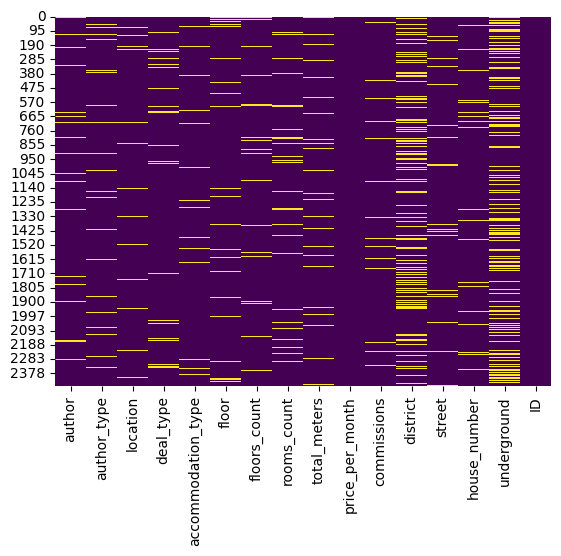

underground           759
district              632
rooms_count           193
street                135
house_number          132
author_type           130
floors_count          130
total_meters          129
author                127
floor                 126
location              125
deal_type             125
accommodation_type    124
commissions           124
price_per_month         0
ID                      0
dtype: int64

In [10]:
sns.heatmap(data_train.isna(), cbar=False, cmap='viridis')
plt.show()
data_train.isna().sum().sort_values(ascending=False)

In [11]:
data_train.nunique()

author                 897
author_type              5
location                15
deal_type                1
accommodation_type       1
floor                   49
floors_count            56
rooms_count              5
total_meters           430
price_per_month        254
commissions              1
district               175
street                 922
house_number           667
underground            214
ID                    2461
dtype: int64

In [12]:
drop = data_train.columns[data_train.nunique() == 1]
data_train.drop(columns=drop, inplace=True)
data_test.drop(columns=drop, inplace=True)
# data_train.drop(columns=['ID'], inplace=True)
# data_test.drop(columns=['ID'], inplace=True)

In [13]:
data_train.nunique()

author              897
author_type           5
location             15
floor                49
floors_count         56
rooms_count           5
total_meters        430
price_per_month     254
district            175
street              922
house_number        667
underground         214
ID                 2461
dtype: int64

In [14]:
data_train.select_dtypes(object).nunique()

author          897
author_type       5
location         15
district        175
street          922
house_number    667
underground     214
dtype: int64

In [15]:
# columns = ['street']  # 'house_number', 'author', 'street', 
# data_train.drop(columns=columns, inplace=True)
# data_test.drop(columns=columns, inplace=True)

In [16]:
for column in data_train.columns[data_train.nunique() <= 200]:
    print(column, data_train[column].unique(), end='\n'*2+'-'*75+'\n'*2)

author_type ['real_estate_agent' nan 'realtor' 'homeowner' 'unknown'
 'official_representative']

---------------------------------------------------------------------------

location ['Смоленск' 'Подольск' 'Иваново' 'Казань' nan 'Люберцы' 'Калуга' 'Москва'
 'Рязань' 'Кашира' 'Брянск' 'Владимир' 'Киров' 'Великий Новгород'
 'Долгопрудный' 'Реутов']

---------------------------------------------------------------------------

floor [15.  1.  5. nan 21.  3.  6. 18.  2. 16.  7. 11. 23. 12. 13.  4. 10. 14.
  9.  8. 44. 17. 28. 19. 31. 41. 24. 46. 22. 20. 25. 60. 26. 37. 36. 33.
 30. 65. 76. 67. 29. 42. 27. 53. 45. 32. 58. 49. 56. 50.]

---------------------------------------------------------------------------

floors_count [19.  3. 32.  5.  8. 25. nan  9. 20.  6. 17.  7.  2. 16. 22. 24. 12. 10.
 23.  4. 27. 11. 14. 15. 48. 13. 18. 31. 30. 78. 33. 26. 75. 77. 47. 40.
 68. 28. 29. 21. 53. 38. 62. 44. 95.  1. 34. 35. 79. 65. 43. 42. 36. 52.
 61. 69. 37.]

-------------------------------------

In [17]:
# data_train.drop(columns=['district', 'underground'], inplace=True)
# data_test.drop(columns=['district', 'underground'], inplace=True)
for column in data_test.columns:
    col = data_train[column]
    col_test = data_test[column]
    if pd.api.types.is_object_dtype(col):
        data_train[column].fillna('unknown11', inplace=True)
        data_test[column].fillna('unknown11', inplace=True)
    elif pd.api.types.is_numeric_dtype(col):
        data_train[column].fillna(col.mean(), inplace=True)
        data_test[column].fillna(col_test.mean(), inplace=True)

In [18]:
data_train.isna().sum().sum()

0

In [19]:
target = 'price_per_month'

In [20]:
X, y = data_train.drop(columns=['ID', target]), data_train[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)  # 0.1
X_test_final = data_test.drop(columns=['ID'])

In [21]:
numeric_features = X.select_dtypes(include=np.number).columns
numeric_transformer = StandardScaler()

categorical_features = X.select_dtypes(include=object).columns
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [22]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)
X_test_final_transformed = preprocessor.transform(X_test_final)

In [23]:
model = nn.Sequential(
    nn.Linear(X_train_transformed.shape[1], 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 1)
)
optimizer = optim.Adam(model.parameters())  # , lr=5e-5
criterion = nn.L1Loss()

In [24]:
# dataset_train = TensorDataset(th.tensor(X_train_transformed.toarray()).float(), th.tensor(y_train.values).float())
# dataset_test = TensorDataset(th.tensor(X_test_transformed.toarray()).float(), th.tensor(y_test.values).float())
# dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)
# dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=True)

In [25]:
# for epoch in range(300):
#     model.train()
#     for X_batch, y_batch in dataloader_train:
#         y_pred = model(X_batch).squeeze()
#         loss = criterion(y_pred, y_batch)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#     model.eval()
#     with th.no_grad():
#         losses = []
#         for X_batch, y_batch in dataloader_test:
#             y_pred = model(X_batch).squeeze()
#             loss = criterion(y_pred, y_batch)
#             losses.append(loss.item())

#         if epoch % 100 == 0:
#             print(f'Epoch {epoch}, loss: {np.mean(losses)}')

In [26]:
X_train_transformed.shape

(1968, 2560)

In [27]:
# Определение устройства
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
print(f'Используется устройство: {device}')

# Перенос модели на устройство
model = nn.Sequential(
    nn.Linear(X_train_transformed.shape[1], 256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 1),
).to(device)

optimizer = optim.Adam(model.parameters(), lr=5e-4)  # Настройка скорости обучения
criterion = nn.MSELoss()

# Создание TensorDataset и DataLoader
dataset_train = TensorDataset(th.tensor(X_train_transformed.toarray()).float(), th.tensor(y_train.values).float())
dataset_val = TensorDataset(th.tensor(X_test_transformed.toarray()).float(), th.tensor(y_test.values).float())

dataloader_train = DataLoader(dataset_train, batch_size=8, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=8, shuffle=False)

# Планировщик скорости обучения
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Параметры для раннего прекращения
patience = 40
best_val_loss = np.inf
epochs_no_improve = 0
best_model_state = None
best_r2 = -np.inf

num_epochs = 2000

for epoch in range(1, num_epochs + 1):
    # Обучение
    model.train()
    train_losses = []
    for X_batch, y_batch in dataloader_train:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        y_pred = model(X_batch).flatten()
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
    
    avg_train_loss = np.mean(train_losses)
    
    # Валидация
    model.eval()
    val_losses = []
    all_preds = []
    all_targets = []
    
    with th.no_grad():
        for X_batch, y_batch in dataloader_val:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            y_pred = model(X_batch).flatten()
            loss = criterion(y_pred, y_batch)
            val_losses.append(loss.item())
            
            all_preds.append(y_pred.cpu().numpy())
            all_targets.append(y_batch.cpu().numpy())
    
    avg_val_loss = np.mean(val_losses)
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    r2 = r2_score(all_targets, all_preds)
    
    # Планировщик
    scheduler.step(avg_val_loss)
    
    # Проверка на улучшение
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_r2 = r2
        epochs_no_improve = 0
        best_model_state = model.state_dict()
    else:
        epochs_no_improve += 1
    
    # Вывод информации
    if epoch % 10 == 0 or epoch == 1:
        print(f'Epoch {epoch} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | R2: {r2:.4f}')
    
    # Раннее прекращение
    if epochs_no_improve >= patience:
        print(f'\nРанняя остановка после {epoch} эпох без улучшений.')
        break

# Загрузка лучшей модели
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print('Лучшая модель загружена.')

# Вычисление финального R2 на валидационном наборе
model.eval()
all_preds = []
all_targets = []

with th.no_grad():
    for X_batch, y_batch in dataloader_val:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        y_pred = model(X_batch).squeeze()
        all_preds.append(np.atleast_1d(y_pred.cpu().numpy()))
        all_targets.append(np.atleast_1d(y_batch.cpu().numpy()))


all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

final_r2 = r2_score(all_targets, all_preds)
print(f'Финальный коэффициент детерминации R^2 на валидационном наборе: {final_r2:.6f}')
print(f'Лучший r2: {best_r2:.6f}')

Используется устройство: cpu
Epoch 1 | Train Loss: 48606585589.8537 | Val Loss: 50810583225.8064 | R2: 0.2955
Epoch 10 | Train Loss: 6881699913.3659 | Val Loss: 10108723600.2581 | R2: 0.8594
Epoch 20 | Train Loss: 2569835940.7561 | Val Loss: 8342939183.6129 | R2: 0.8841
Epoch 30 | Train Loss: 582925343.4827 | Val Loss: 7488802494.3226 | R2: 0.8963
Epoch 40 | Train Loss: 215634194.4121 | Val Loss: 6835530153.2903 | R2: 0.9056
Epoch 50 | Train Loss: 85361257.6504 | Val Loss: 7027290046.0645 | R2: 0.9026
Epoch 60 | Train Loss: 72797924.7867 | Val Loss: 6986987081.6774 | R2: 0.9032
Epoch 70 | Train Loss: 71298505.2620 | Val Loss: 6985228551.1613 | R2: 0.9032

Ранняя остановка после 71 эпох без улучшений.
Лучшая модель загружена.
Финальный коэффициент детерминации R^2 на валидационном наборе: 0.903208
Лучший r2: 0.905476


In [28]:
# Предсказание на X_test_final
model.eval()
test_preds = []

with th.no_grad():
    # Преобразование данных теста в Tensor и перенос на устройство
    X_test_final_tensor = th.tensor(X_test_final_transformed.toarray()).float().to(device)
    
    # Получение предсказаний
    y_test_pred = model(X_test_final_tensor).squeeze()
    
    # Перевод предсказаний на CPU и в numpy
    test_preds = y_test_pred.cpu().numpy()

# Предполагается, что у вас сохранен столбец 'ID' из исходного data_test до его удаления
# Например, до удаления 'ID':
# test_ids = pd.read_csv('./rent-prediction/test.csv')['ID']

# Создание DataFrame с ID и предсказанными ценами
submission_df = pd.DataFrame({
    'ID': data_test['ID'],  # Замените 'test_ids' на вашу переменную с ID
    'price_per_month': test_preds
})

# Сохранение в CSV файл
submission_df.to_csv('submission.csv', index=False)